In [1]:
!pip install pystan==2.19.1.1
!pip install prophet

In [1]:
import os
import glob
import csv
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge

from darts.metrics import mae
from darts.metrics import mse
from darts.metrics import rmse

import random
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.plot import add_changepoints_to_plot
import datetime

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler

In [2]:
def interpolate_method(df,column_name,methode,direction,order,limit):
  df[column_name] = df[column_name].interpolate(method=methode,limit_direction = direction,order=order,limit=limit)
  return df

def clean_csv(df,time_variable,quantitative_variable):
  df = df[[time_variable, quantitative_variable]].copy()
  df.columns = ['ds','y']
  df['y'] = (df['y'].apply(pd.to_numeric, errors='coerce')).to_frame()
  df = df.drop_duplicates(subset=['ds'])
  df['ds'] = pd.to_datetime(df.ds, errors = 'coerce')
  df = df.dropna(subset=['ds'])
  df = df.sort_values(by=['ds'])
  pourcentage = ((len(df) - df['y'].count()) / len(df)) * 100
  if (pourcentage <= 2):
    df = df.dropna(subset=['y'])
  elif((pourcentage > 2) and (pourcentage < 25)):
    df = interpolate_method(df,'y',"polynomial",None,2,None)
  elif((pourcentage >= 25)):
    print("La base de donnée comporte un grand nombre de données manquantes pour être étudiée.")
  if(len(df) > 1000):
      supr = len(df) - 1000
      df = df[:-supr]
  return df, pourcentage

In [3]:
def naive_method(df):
  if len(df.columns) > 2:
    print("Erreur : il y a plus d'une seule variable")
  elif(len(df) < 500):
      print("Erreur : le data frame est trop petit")
  else:
    n = len(df)
    period = 100
    train_len = n-period
    train = df[0:train_len]
    val = df[train_len:]
    
    series = TimeSeries.from_dataframe(df, 'ds', 'y')
    train_scaled = TimeSeries.from_dataframe(train, 'ds', 'y')
    val_scaled = TimeSeries.from_dataframe(val, 'ds', 'y')
    
    scaler = Scaler()
    train_scaled = scaler.fit_transform(train_scaled)
    val_scaled = scaler.transform(val_scaled)
    series_scaled = scaler.transform(series)
        
    y_hat_naive = val.copy()
    y_hat_naive['naive_forecast'] = train['y'][train_len-1]
    
    y_hat_naive_scaled = TimeSeries.from_dataframe(y_hat_naive, 'ds', 'naive_forecast')
    y_hat_naive_scaled = scaler.transform(y_hat_naive_scaled)
    
    MAE = mae(val_scaled,y_hat_naive_scaled)
    MSE = mse(val_scaled,y_hat_naive_scaled)
    RMSE = rmse(val_scaled,y_hat_naive_scaled)


    return(train_scaled, val_scaled, y_hat_naive_scaled, MAE, MSE, RMSE)

In [4]:
def prophet_model(df,frequency):
  if len(df.columns) > 2:
    print("Erreur : il y a plus d'une seule variable")
  elif(len(df) < 500):
    print("Erreur : le data frame est trop petit")
  else:
    n = len(df)
    period = 100
    df_fit = df[:-period]
    df_true = df[n-period:]
    
    series = TimeSeries.from_dataframe(df, 'ds', 'y')
    train = TimeSeries.from_dataframe(df_fit, 'ds', 'y')
    val = TimeSeries.from_dataframe(df_true, 'ds', 'y')
    
    scaler = Scaler()
    train_scaled = scaler.fit_transform(train)
    val_scaled = scaler.transform(val)
    series_scaled = scaler.transform(series)
    
    m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality = True)
    m.fit(df_fit)
    future = m.make_future_dataframe(periods=period*2, freq=frequency)
    if (frequency == 'M'):
        for i in range (n-period, len(future)):
            future['ds'][i] = future['ds'][i] + datetime.timedelta(days=1)
    forecast = m.predict(future)
    df_true_prediction = pd.merge(df_true, forecast, how ='inner', on =['ds'])
    df_true_prediction = df_true_prediction[['ds', 'y', 'yhat', 'yhat_upper', 'yhat_lower']].copy()
    
    pred = TimeSeries.from_dataframe(df_true_prediction, 'ds', 'yhat')
    pred_scaled = scaler.transform(pred)
    
    MAE = mae(val_scaled,pred_scaled)
    MSE = mse(val_scaled,pred_scaled)
    RMSE = rmse(val_scaled, pred_scaled)
    
    return(train_scaled, val_scaled, pred_scaled, MAE, MSE, RMSE)

In [5]:
os.getcwd()

'/home/nazim/MAIN4/Transformers/Code/900-100'

In [6]:
os.chdir('../../Datasets/Données_Démographiques')
os.getcwd()

'/home/nazim/MAIN4/Transformers/Datasets/Données_Démographiques'

In [7]:
!ls

D-dep_02.csv  D-dep_08.csv  D-dep-77.csv  D-dep-92.csv
D-dep_04.csv  D-dep_09.csv  D-dep-78.csv  D-dep-93.csv
D-dep_06.csv  D-dep-74.csv  D-dep-90.csv  D-dep-94.csv
D-dep_07.csv  D-dep-75.csv  D-dep-91.csv  D-dep-95.csv


In [8]:
def predict():
    file_name = []
    df = []
    pourcentage = []

    df_fit_naive = []
    df_true_prediction_naive = []
    forecast_naive = []

    df_fit_prophet = []
    df_true_prediction_prophet = []
    forecast_prophet = []

    results_naive = pd.DataFrame(columns=['DATA_SET_NAME','Method','MAE','MSE','RMSE'])
    results_prophet = pd.DataFrame(columns=['DATA_SET_NAME','Method','MAE','MSE','RMSE'])

    i = 0
    for files in glob.glob("*.csv"):
        file_name.append(Path(files).stem)
        print(file_name[i])
        df_not_cleaned = pd.read_csv(files)
        df_clean, pourcentage_actual = clean_csv(df_not_cleaned, "Date","Value")
        df.append(df_clean)
        pourcentage.append(pourcentage_actual)

        df_fit_temp_naive , df_true_prediction_temp_naive , forecast_temp_naive , MAE_naive, MSE_naive, RMSE_naive = naive_method(df[i])
        df_fit_naive.append(df_fit_temp_naive)
        df_true_prediction_naive.append(df_true_prediction_temp_naive)
        forecast_naive.append(forecast_temp_naive)

        df_fit_temp_prophet , df_true_prediction_temp_prophet , forecast_temp_prophet , MAE_prophet, MSE_prophet, RMSE_prophet = prophet_model(df[i],file_name[i][0])
        df_fit_prophet.append(df_fit_temp_prophet)
        df_true_prediction_prophet.append(df_true_prediction_temp_prophet)
        forecast_prophet.append(forecast_temp_prophet)

        df_new_row_naive = pd.DataFrame(data=np.array([[file_name[i],'Naive Method',MAE_naive,MSE_naive,RMSE_naive]]), columns=['DATA_SET_NAME','Method','MAE','MSE','RMSE'])
        df_new_row_prophet = pd.DataFrame(data=np.array([[file_name[i],'Prophet Method',MAE_prophet,MSE_prophet,RMSE_prophet]]), columns=['DATA_SET_NAME','Method','MAE','MSE','RMSE'])
        results_naive = pd.concat([results_naive,df_new_row_naive], ignore_index=True)
        results_prophet = pd.concat([results_prophet,df_new_row_prophet], ignore_index=True)
        i = i +1

    return file_name,df, pourcentage, df_fit_naive, df_true_prediction_naive, forecast_naive, results_naive, df_fit_prophet, df_true_prediction_prophet, forecast_prophet, results_prophet

In [9]:
file_name, df, pourcentage, df_fit_naive, df_true_prediction_naive, forecast_naive, results_naive, df_fit_prophet, df_true_prediction_prophet, forecast_prophet, results_prophet = predict()

D-dep-93
Initial log joint probability = -7.35779
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      83       1813.81   0.000304308       145.289   1.958e-06       0.001      146  LS failed, Hessian reset 
      99       1814.09   8.16811e-05        84.436      0.4707      0.4707      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150       1815.03   0.000263891       130.908   2.026e-06       0.001      263  LS failed, Hessian reset 
     199       1816.09   0.000277479       87.0538           1           1      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     271        1816.7   0.000473374       190.984   3.574e-06       0.001      469  LS failed, Hessian reset 
     299       1816.89   3.31673e-05       86.4725      0.5805      0.5805      500   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # ev

D-dep_04
Initial log joint probability = -13.0827
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1308.64   4.31789e-07       78.0124           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       1308.64   5.88221e-08       79.5071       0.261           1      134   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
D-dep_07
Initial log joint probability = -24.6324
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1396.46   0.000138533       65.1377       0.807       0.807      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       1396.52   0.000384021       81.4165   5.227e-06       0.001      166  LS failed, Hessian reset 
     162       1396.61   4.68117e-05       73.4576   5

In [10]:
df

[            ds   y
 0   2019-01-01  19
 1   2019-01-02  35
 2   2019-01-03  20
 3   2019-01-04  27
 4   2019-01-05  29
 ..         ...  ..
 995 2021-09-22  16
 996 2021-09-23  20
 997 2021-09-24  21
 998 2021-09-25  20
 999 2021-09-26  19
 
 [1000 rows x 2 columns],
             ds   y
 0   2019-01-01  19
 1   2019-01-02  19
 2   2019-01-03  16
 3   2019-01-04  16
 4   2019-01-05  20
 ..         ...  ..
 995 2021-09-22  14
 996 2021-09-23  14
 997 2021-09-24   9
 998 2021-09-25  12
 999 2021-09-26  20
 
 [1000 rows x 2 columns],
             ds   y
 0   2019-01-01  29
 1   2019-01-02  30
 2   2019-01-03  15
 3   2019-01-04  20
 4   2019-01-05  28
 ..         ...  ..
 995 2021-09-22  18
 996 2021-09-23  19
 997 2021-09-24  21
 998 2021-09-25  24
 999 2021-09-26  19
 
 [1000 rows x 2 columns],
             ds   y
 0   2019-01-01  23
 1   2019-01-02  19
 2   2019-01-03  28
 3   2019-01-04  23
 4   2019-01-05  32
 ..         ...  ..
 995 2021-09-22  22
 996 2021-09-23  23
 997 2021-09-24 

In [11]:
results_naive

,DATA_SET_NAME,Method,MAE,MSE,RMSE
0,D-dep-93,Naive Method,0.043173076923076925,0.002798631656804734,0.05290209501338047
1,D-dep_02,Naive Method,0.21,0.05205000000000002,0.22814469093099674
2,D-dep-91,Naive Method,0.05493333333333335,0.004714666666666667,0.06866343034444658
3,D-dep-95,Naive Method,0.10481012658227847,0.013260695401377977,0.11515509281563702
4,D-dep-78,Naive Method,0.065,0.0061998456790123445,0.07873909879476869
5,D-dep_09,Naive Method,0.13599999999999998,0.030488888888888885,0.17461067804945057
6,D-dep-94,Naive Method,0.0404424778761062,0.0025898660819171438,0.050890726875503986
7,D-dep-74,Naive Method,0.05833333333333332,0.005661865569272974,0.0752453690885557
8,D-dep_06,Naive Method,0.13014084507042256,0.022737552073001387,0.1507897611676648
9,D-dep_04,Naive Method,0.106875,0.0194140625,0.1393343550600497


In [12]:
results_prophet

,DATA_SET_NAME,Method,MAE,MSE,RMSE
0,D-dep-93,Prophet Method,0.046951337523100406,0.00384914810261034,0.0620415030653702
1,D-dep_02,Prophet Method,0.07368754201624536,0.008422473287276529,0.09177403384006028
2,D-dep-91,Prophet Method,0.05888157245606247,0.005296560594753111,0.07277747312701308
3,D-dep-95,Prophet Method,0.0655707220971607,0.006314219225324379,0.07946206154715833
4,D-dep-78,Prophet Method,0.05864115094927296,0.005282967667406991,0.07268402621901865
5,D-dep_09,Prophet Method,0.13323087535582614,0.028312549556066737,0.1682633339621759
6,D-dep-94,Prophet Method,0.04076125919238151,0.002710616180134162,0.052063578249426555
7,D-dep-74,Prophet Method,0.0626307339479814,0.0064764377251184365,0.08047631779050553
8,D-dep_06,Prophet Method,0.08240280225357945,0.01008970383808889,0.10044751782940627
9,D-dep_04,Prophet Method,0.12171560373203723,0.022792917933720406,0.1509732358192021


In [13]:
results_prophet.to_csv(r'../../Resultats/Resultats_100/prophet_results_demog.csv', index = False)
results_naive.to_csv(r'../../Resultats/Resultats_100/naive_results_demog.csv', index = False)

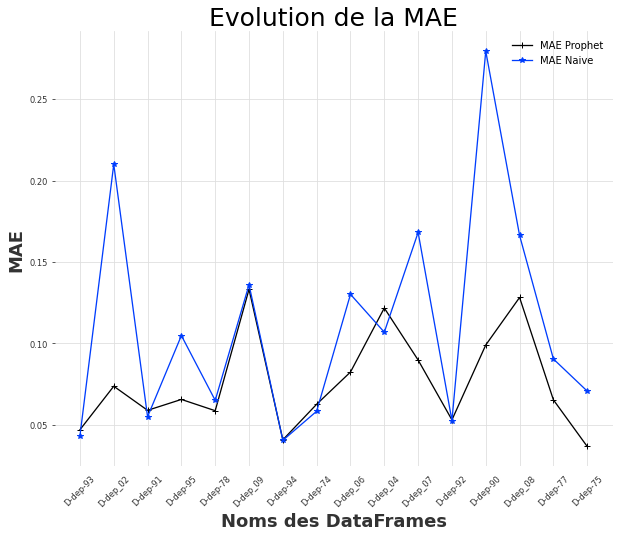

In [14]:
figure(figsize=(10, 8))
plt.axes()

liste_MAE1_prophet = results_prophet["MAE"].tolist()
liste_MAE_prophet = [float(item) for item in liste_MAE1_prophet]

liste_MAE1_naive = results_naive["MAE"].tolist()
liste_MAE_naive = [float(item) for item in liste_MAE1_naive]

x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
y = np.array(liste_MAE_prophet)
y2 = np.array(liste_MAE_naive)

liste_NAME = results_prophet["DATA_SET_NAME"].tolist()
my_xticks = liste_NAME
plt.xticks(x, my_xticks)
plt.xticks(rotation=45)
plt.plot(x, y, label = 'MAE Prophet', marker="+")
plt.plot(x, y2, label = 'MAE Naive', marker="*")
plt.title("Evolution de la MAE",fontsize=25)
plt.xlabel("Noms des DataFrames",fontsize=18)
plt.ylabel("MAE",fontsize=18)
plt.legend()
plt.show()

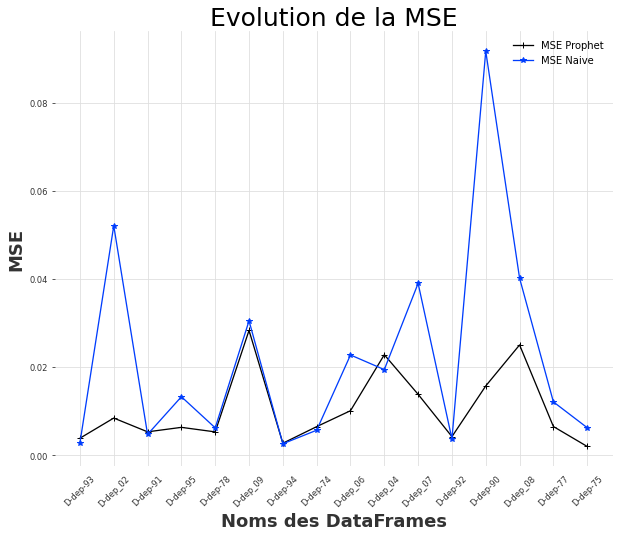

In [15]:
figure(figsize=(10, 8))
plt.axes()

liste_MSE1_prophet = results_prophet["MSE"].tolist()
liste_MSE_prophet = [float(item) for item in liste_MSE1_prophet]

liste_MSE1_naive = results_naive["MSE"].tolist()
liste_MSE_naive = [float(item) for item in liste_MSE1_naive]

x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
y = np.array(liste_MSE_prophet)
y2 = np.array(liste_MSE_naive)

liste_NAME = results_prophet["DATA_SET_NAME"].tolist()
my_xticks = liste_NAME
plt.xticks(x, my_xticks)
plt.xticks(rotation=45)
plt.plot(x, y, label = 'MSE Prophet', marker="+")
plt.plot(x, y2, label = 'MSE Naive', marker="*")
plt.title("Evolution de la MSE",fontsize=25)
plt.xlabel("Noms des DataFrames",fontsize=18)
plt.ylabel("MSE",fontsize=18)
plt.legend()
plt.show()

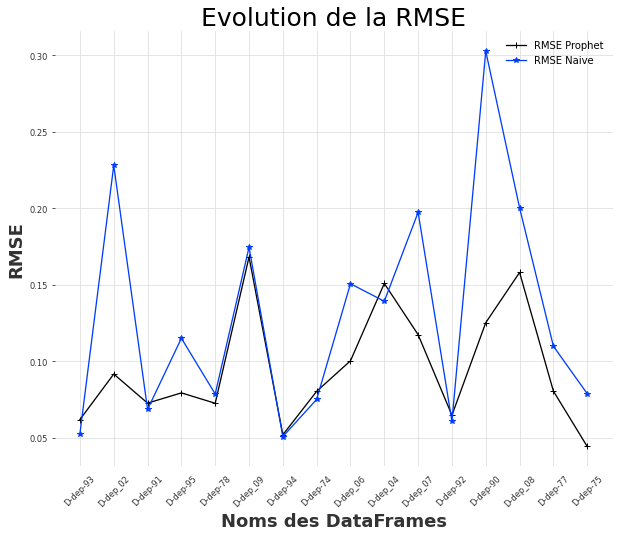

In [16]:
figure(figsize=(10, 8))
plt.axes()

liste_RMSE1_prophet = results_prophet["RMSE"].tolist()
liste_RMSE_prophet = [float(item) for item in liste_RMSE1_prophet]

liste_RMSE1_naive = results_naive["RMSE"].tolist()
liste_RMSE_naive = [float(item) for item in liste_RMSE1_naive]

x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
y = np.array(liste_RMSE_prophet)
y2 = np.array(liste_RMSE_naive)

liste_NAME = results_prophet["DATA_SET_NAME"].tolist()
my_xticks = liste_NAME
plt.xticks(x, my_xticks)
plt.xticks(rotation=45)
plt.plot(x, y, label = 'RMSE Prophet', marker="+")
plt.plot(x, y2, label = 'RMSE Naive', marker="*")
plt.title("Evolution de la RMSE",fontsize=25)
plt.xlabel("Noms des DataFrames",fontsize=18)
plt.ylabel("RMSE",fontsize=18)
plt.legend()
plt.show()

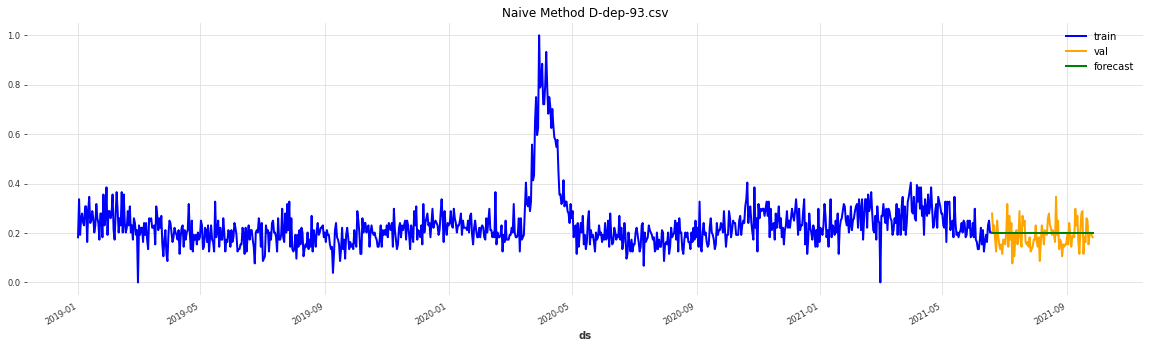

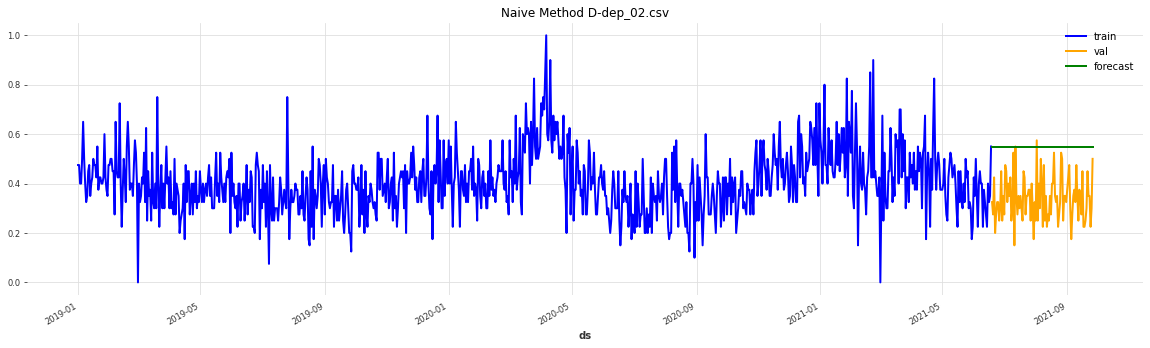

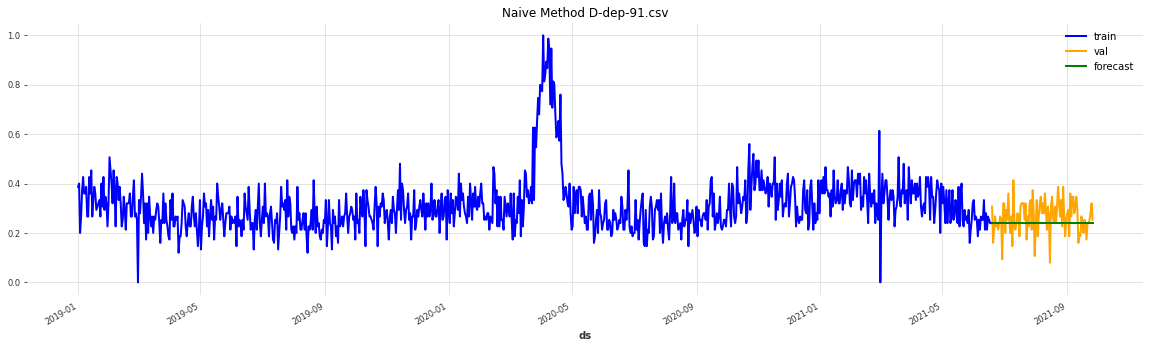

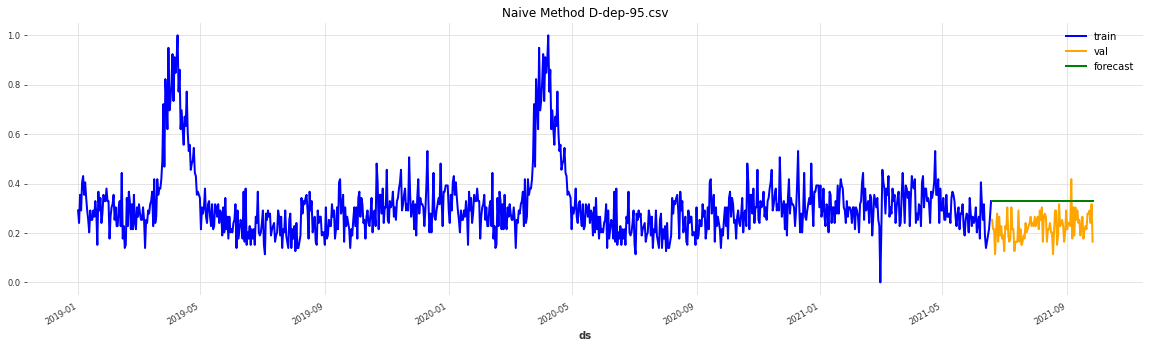

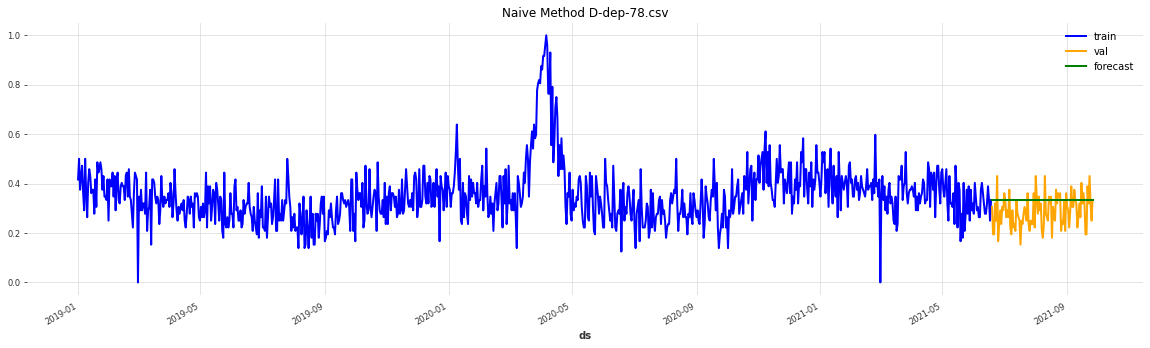

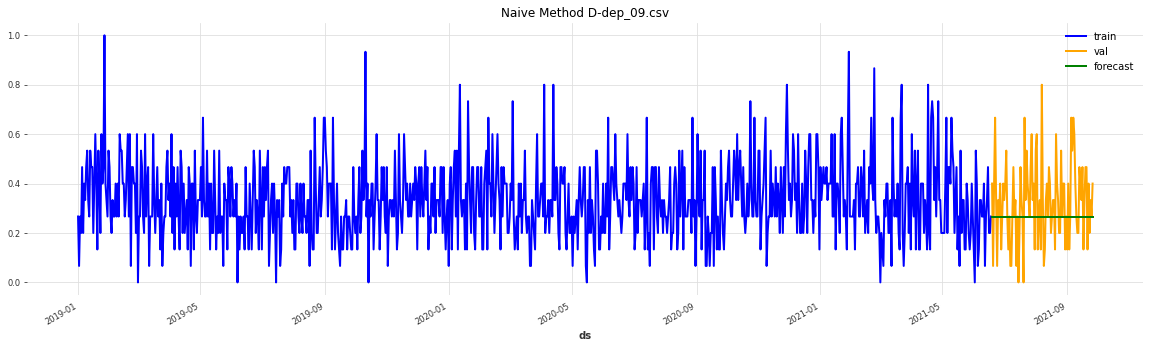

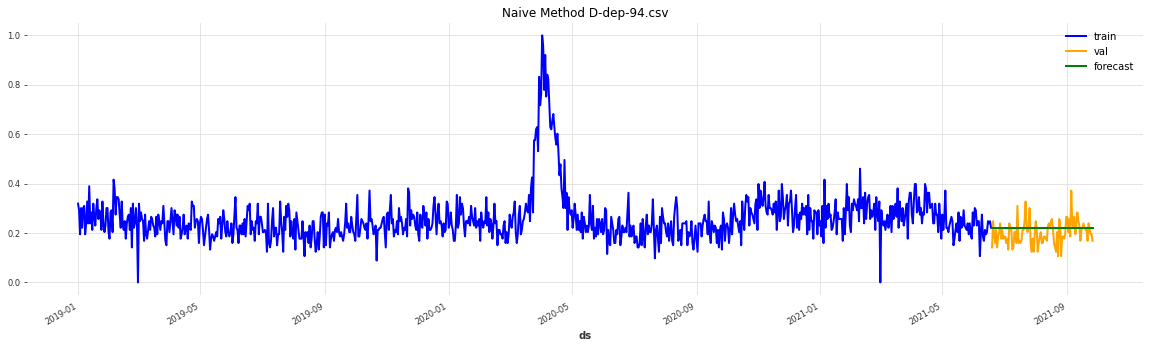

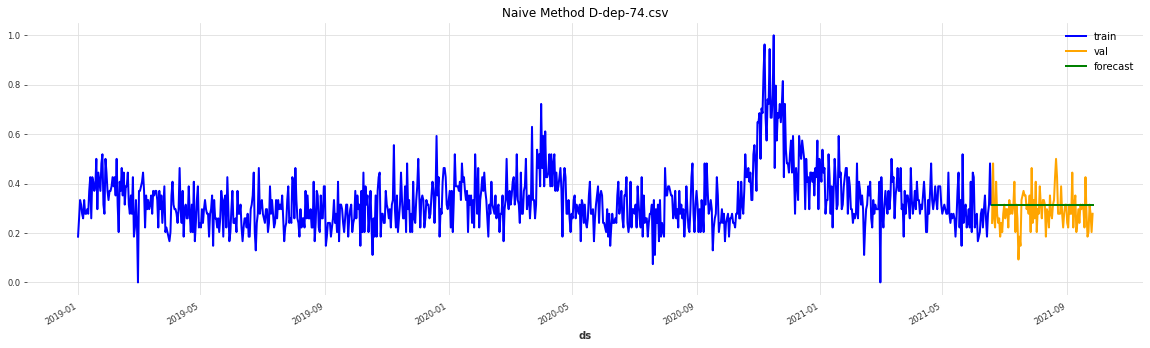

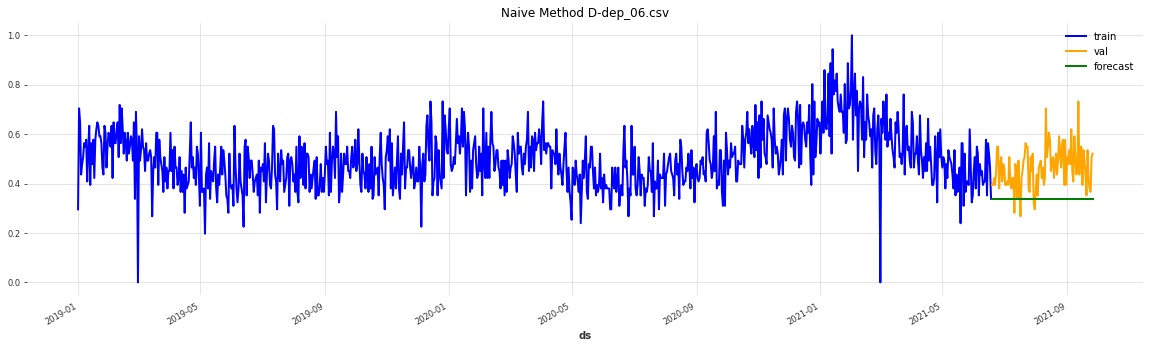

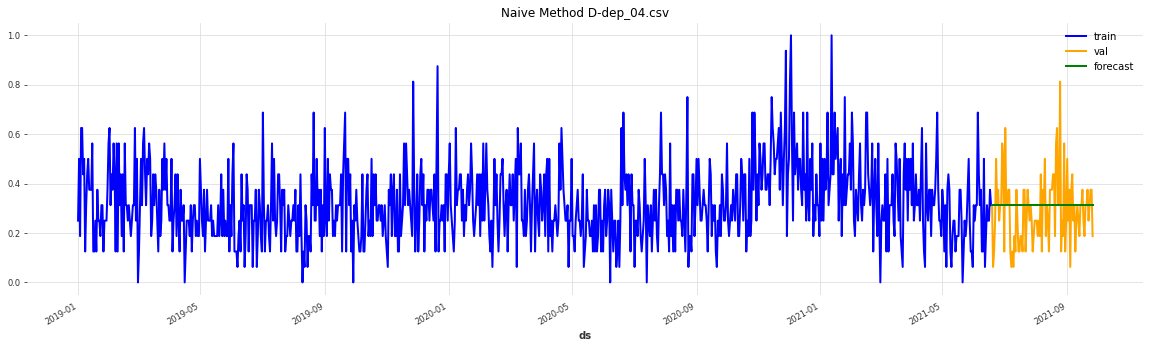

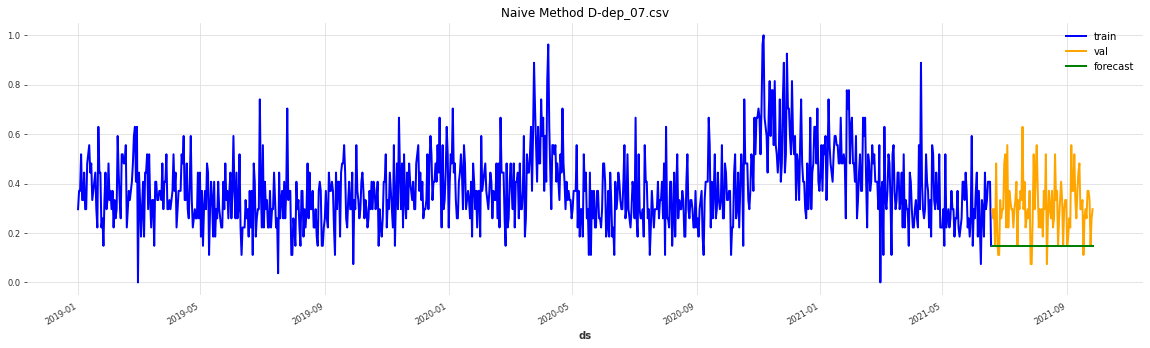

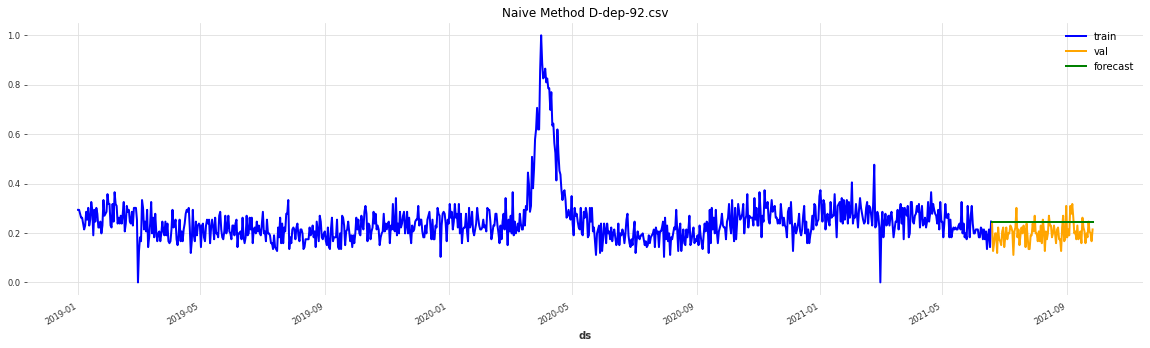

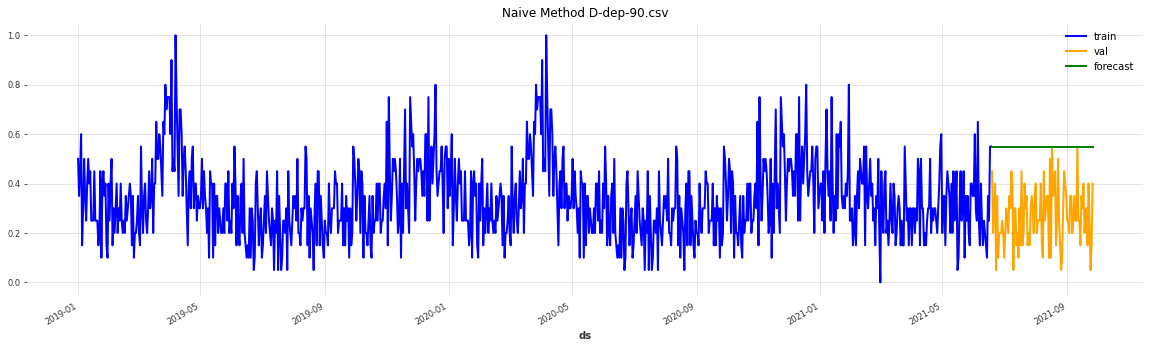

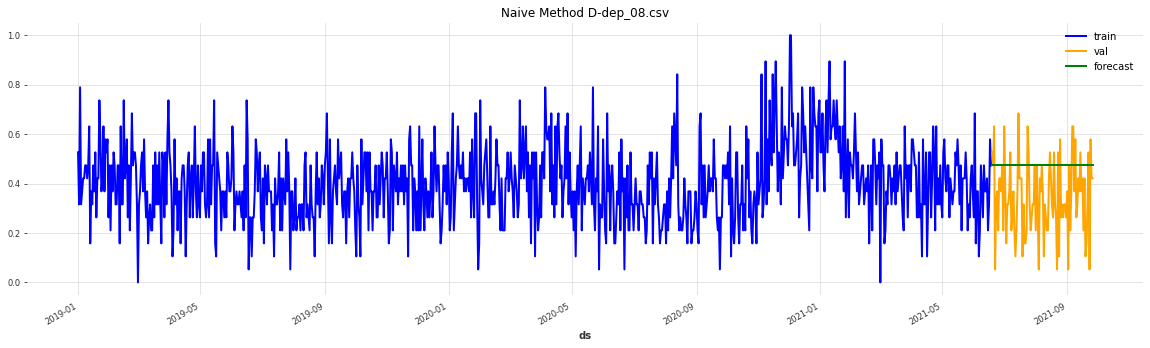

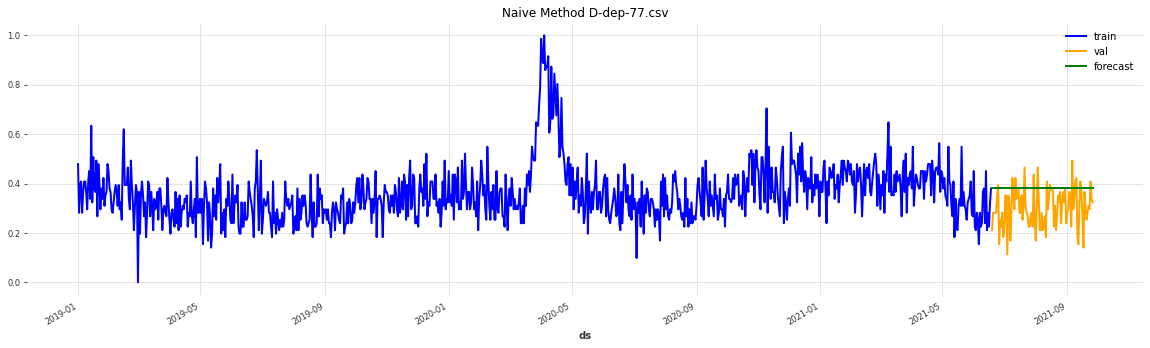

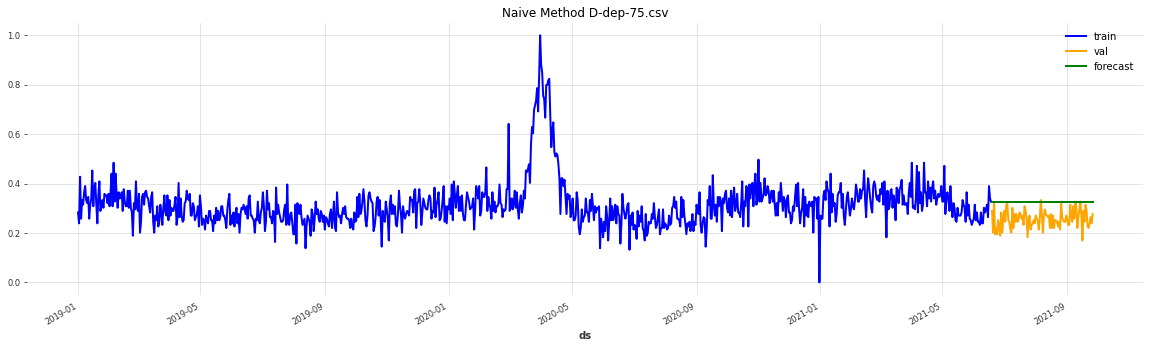

In [17]:
for i in range(len(df_fit_naive)):
    plt.figure(figsize=(20,5))
    df_fit_naive[i].plot(color ='blue', label="train")
    df_true_prediction_naive[i].plot(color ='orange', label="val")
    forecast_naive[i].plot(color ='green',label="forecast")
    plt.title('Naive Method '+file_name[i]+".csv")    
    plt.legend(loc='best')
    plt.show()

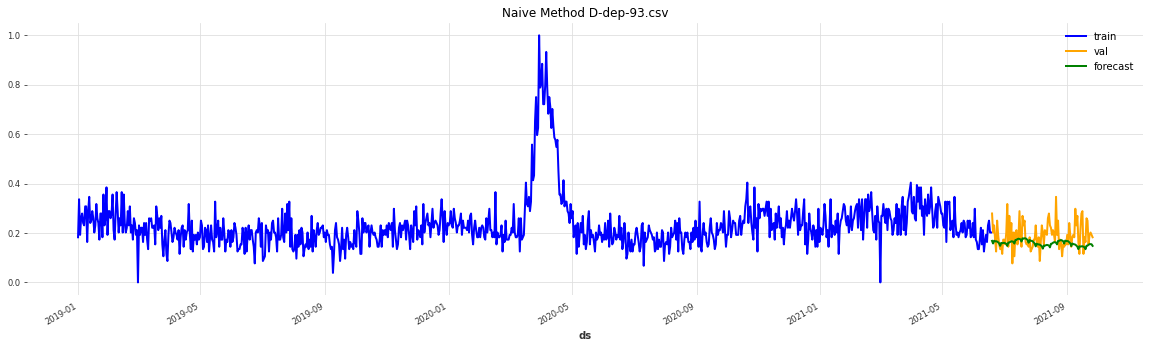

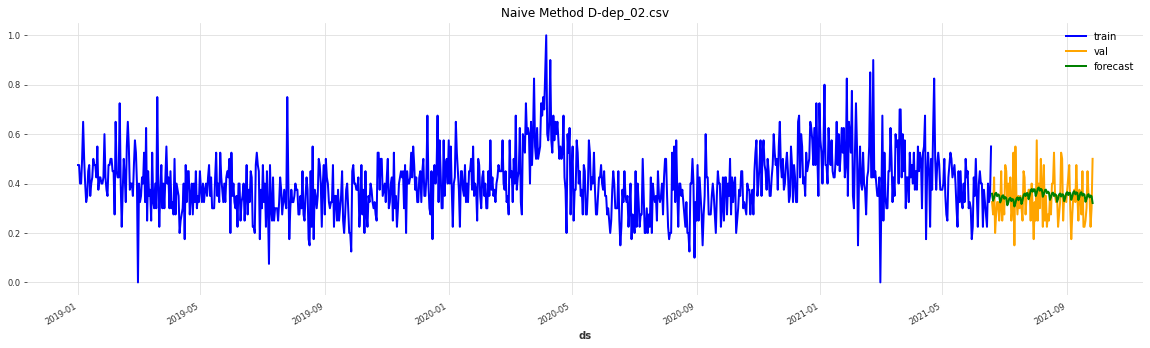

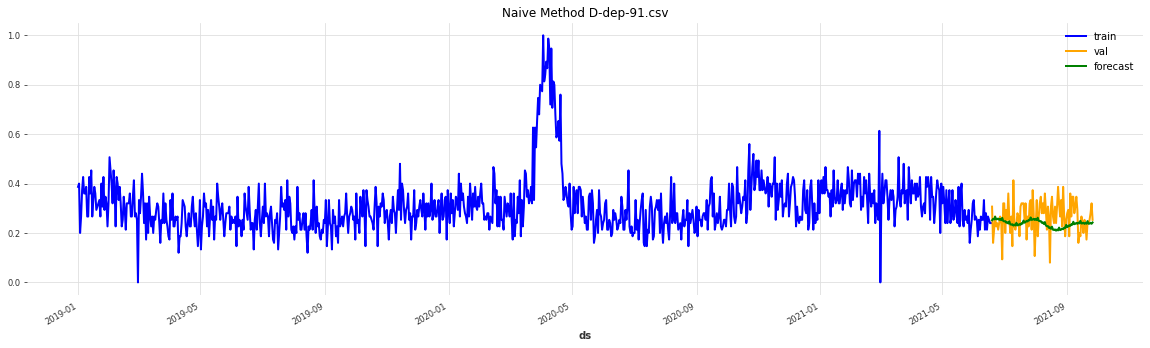

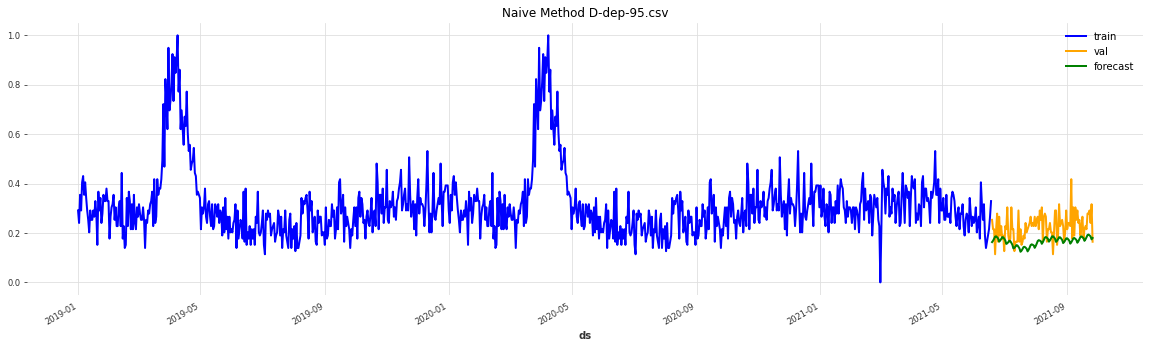

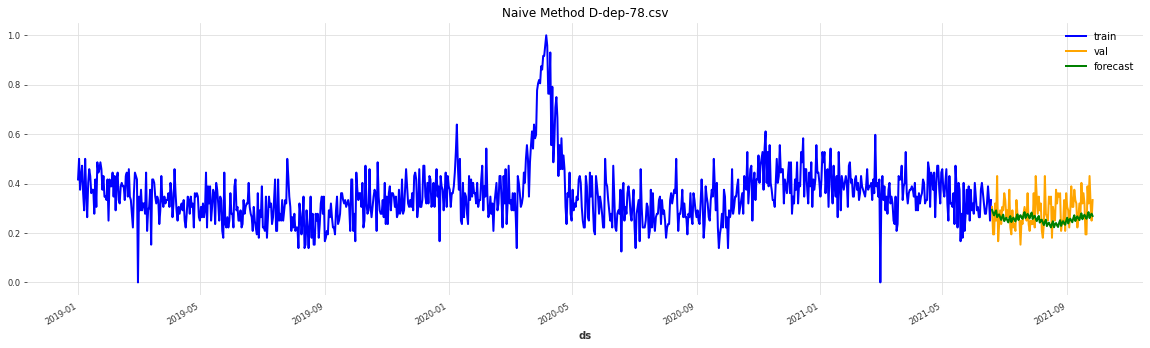

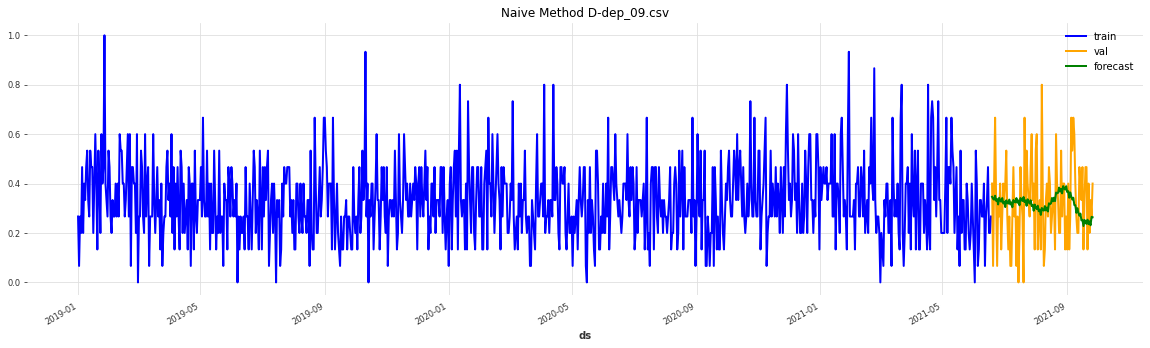

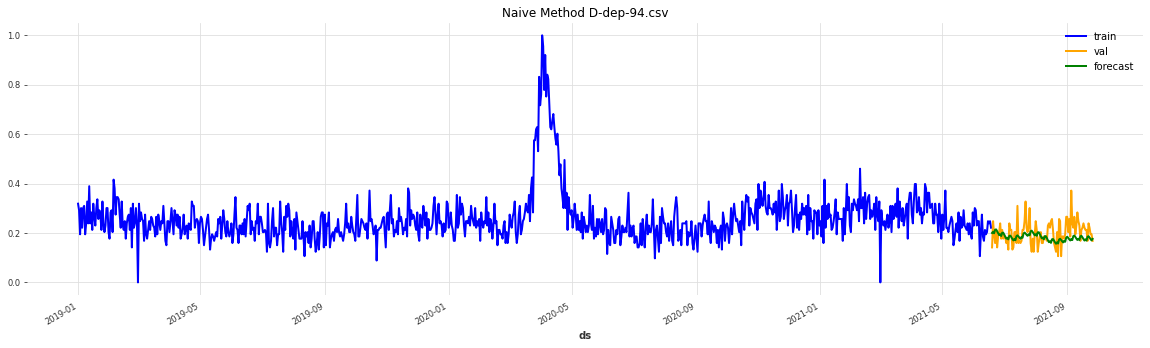

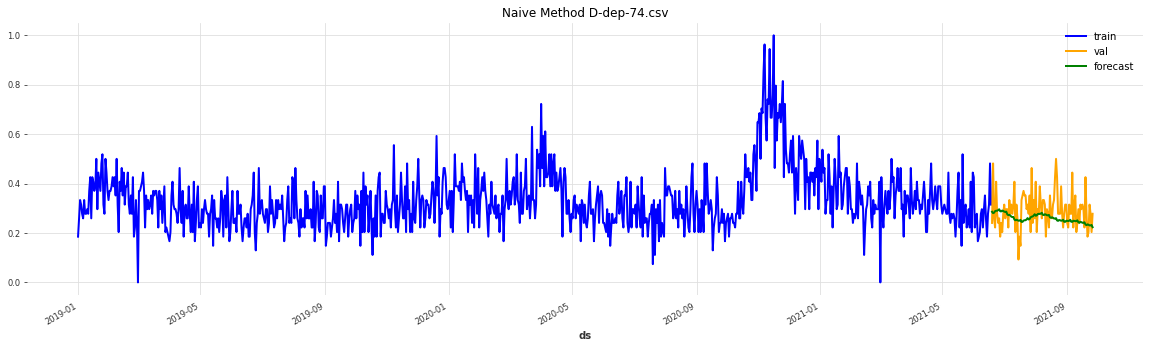

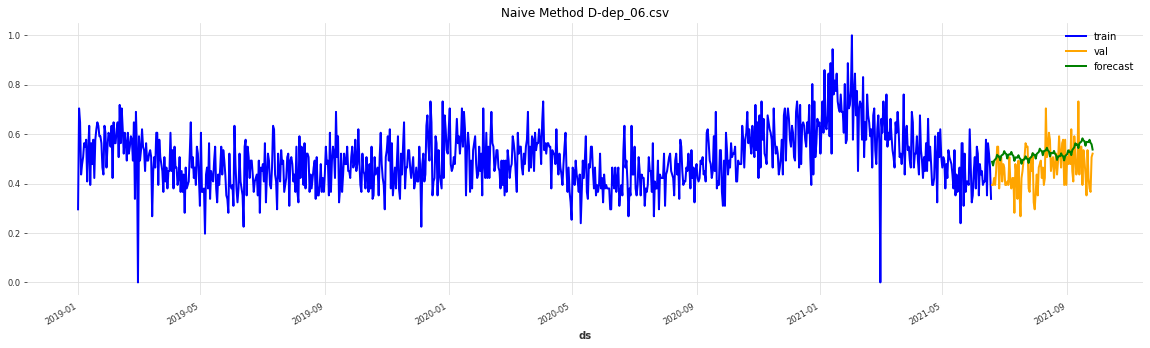

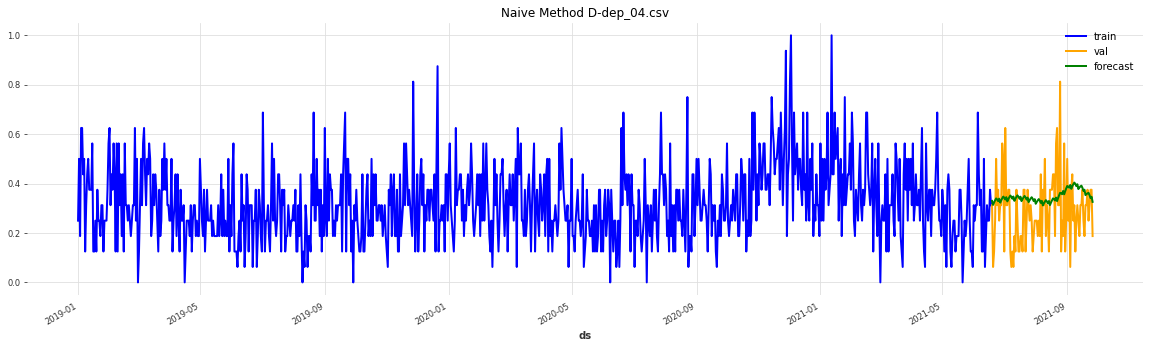

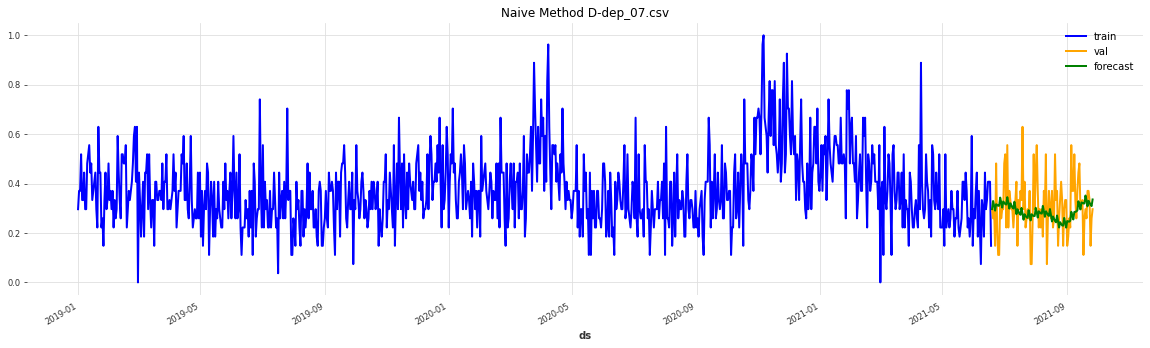

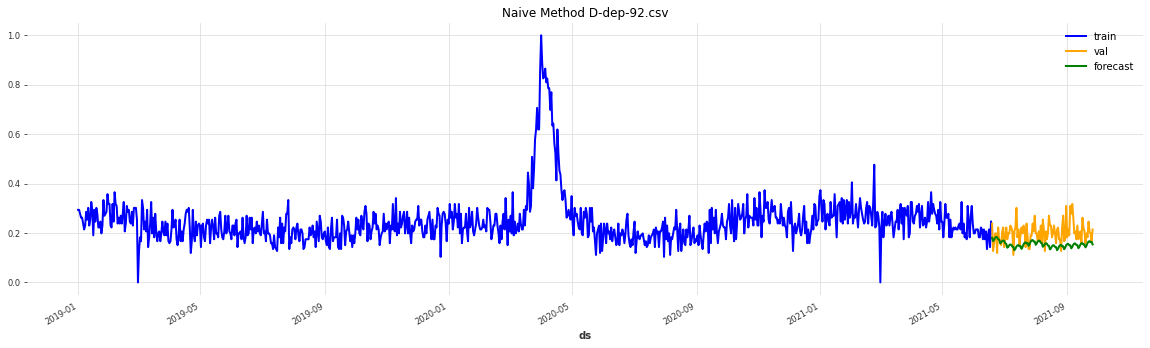

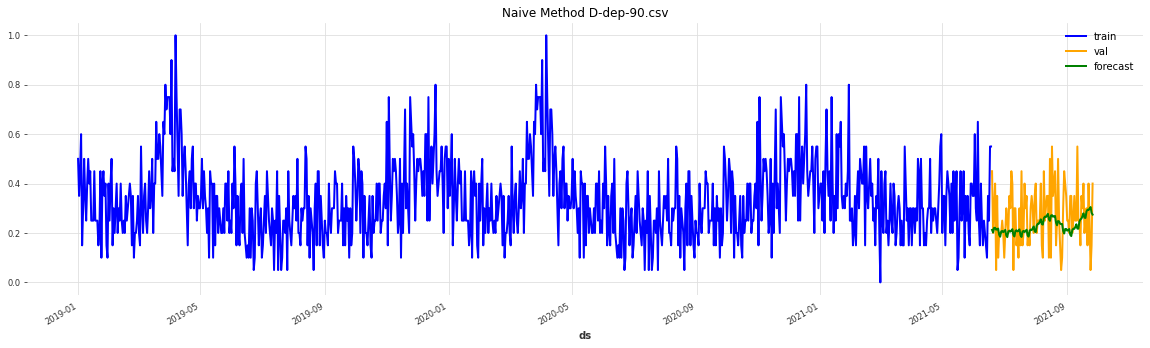

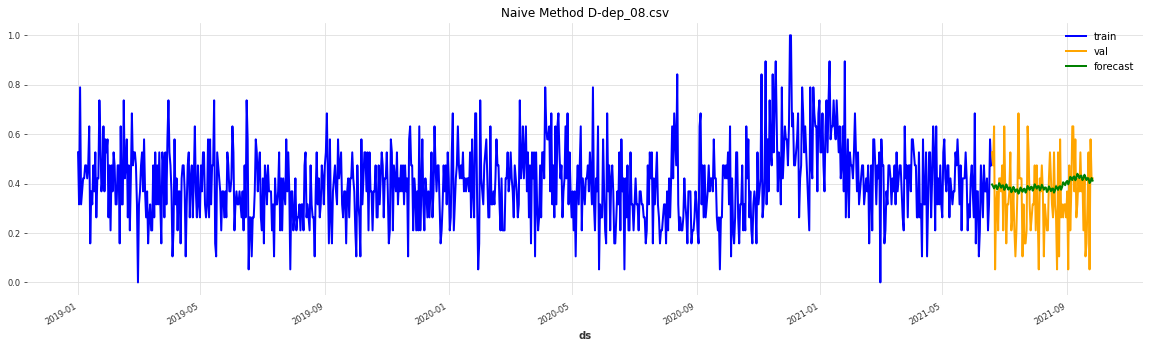

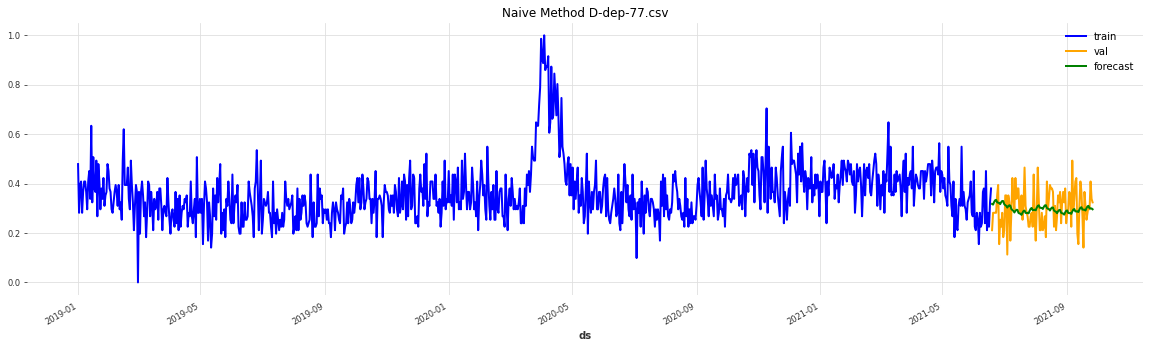

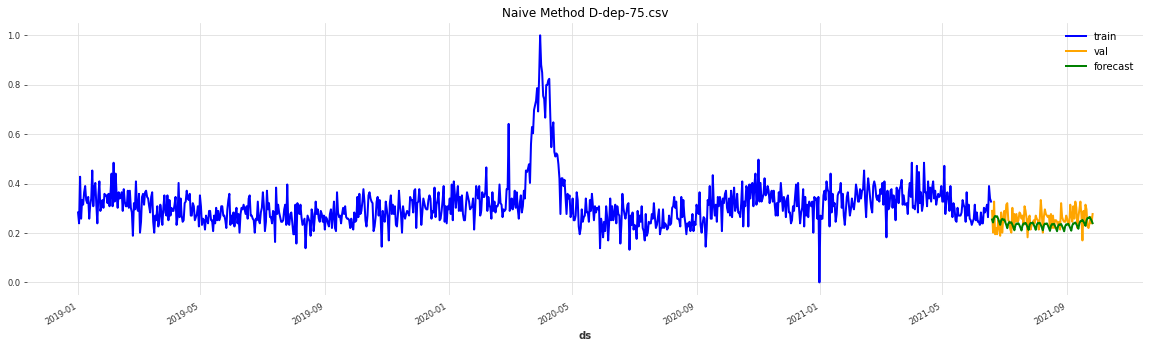

In [18]:
for i in range(len(df_fit_prophet)):
    plt.figure(figsize=(20,5))
    df_fit_prophet[i].plot(color ='blue', label="train")
    df_true_prediction_prophet[i].plot(color ='orange', label="val")
    forecast_prophet[i].plot(color ='green',label="forecast")
    plt.title('Naive Method '+file_name[i]+".csv")    
    plt.legend(loc='best')
    plt.show()

In [19]:
for i in range(len(df_fit_naive)):
    if len(df_fit_naive[i]) != 900 :
        print("ERROR, len(df_fit_naive[{}] = ".format(i, len(df_fit_naive[i])))
    elif len(df_true_prediction_naive[i]) != 100 :
        print("ERROR, len(df_true_prediction_naive[{}] = ".format(i, len(df_true_prediction_naive[i])))
    else:
        print("Tout est bon pour data i = ", i)
    print("-----")

Tout est bon pour data i =  0
-----
Tout est bon pour data i =  1
-----
Tout est bon pour data i =  2
-----
Tout est bon pour data i =  3
-----
Tout est bon pour data i =  4
-----
Tout est bon pour data i =  5
-----
Tout est bon pour data i =  6
-----
Tout est bon pour data i =  7
-----
Tout est bon pour data i =  8
-----
Tout est bon pour data i =  9
-----
Tout est bon pour data i =  10
-----
Tout est bon pour data i =  11
-----
Tout est bon pour data i =  12
-----
Tout est bon pour data i =  13
-----
Tout est bon pour data i =  14
-----
Tout est bon pour data i =  15
-----


In [20]:
for i in range(len(df_fit_prophet)):
    if len(df_fit_prophet[i]) != 900 :
        print("ERROR, len(df_fit_prophet[{}] = ".format(i, len(df_fit_prophet[i])))
    elif len(df_true_prediction_prophet[i]) != 100 :
        print("ERROR, len(df_true_prediction_prophet[{}] = ".format(i, len(df_true_prediction_prophet[i])))
    else:
        print("Tout est bon pour data i = ", i)
    print("-----")

Tout est bon pour data i =  0
-----
Tout est bon pour data i =  1
-----
Tout est bon pour data i =  2
-----
Tout est bon pour data i =  3
-----
Tout est bon pour data i =  4
-----
Tout est bon pour data i =  5
-----
Tout est bon pour data i =  6
-----
Tout est bon pour data i =  7
-----
Tout est bon pour data i =  8
-----
Tout est bon pour data i =  9
-----
Tout est bon pour data i =  10
-----
Tout est bon pour data i =  11
-----
Tout est bon pour data i =  12
-----
Tout est bon pour data i =  13
-----
Tout est bon pour data i =  14
-----
Tout est bon pour data i =  15
-----
